In [34]:
import os, json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

In [53]:
INPUT_FILES = {
'Hermione': 'data/hermione_granger_classified.csv',
'Ron': 'data/ron_weasley_classified.csv',
'Dumbledore': 'data/albus_dumbledore_classified.csv'
}

In [65]:
dfs = {}
for char, fn in INPUT_FILES.items():
    dfs[char] = pd.read_csv(fn)
    dfs[char]["Character Name"] = char
    # ensure strings
    dfs[char]["Dialogue"] = dfs[char]["Dialogue"].astype(str)
    dfs[char]["Topic"] = dfs[char]["Topic"].astype(str)

rename_dict = {
    "magical theory & practice": "magic",
    "dark arts & danger": "threats",
    "quest & strategy": "strategy",
    "emotional & relationships": "social dynamics"
}

for df in dfs.values():
    df["Topic"] = df["Topic"].replace(rename_dict)

combined_df = pd.concat(list(dfs.values()), ignore_index=True)

In [66]:
print("Loaded character lines:")
for c, df in dfs.items():
    print(f"  {c}: {len(df)} lines, {df['Topic'].nunique()} topics")
print("Total:", len(combined_df))

Loaded character lines:
  Hermione: 300 lines, 7 topics
  Ron: 300 lines, 7 topics
  Dumbledore: 300 lines, 7 topics
Total: 900


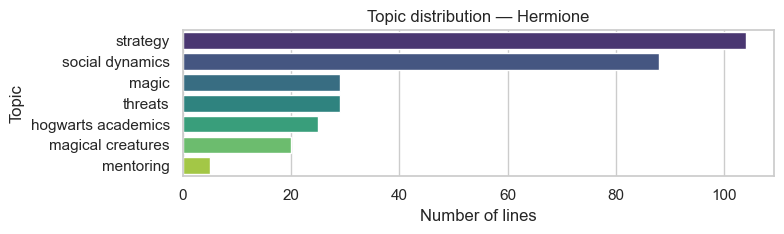

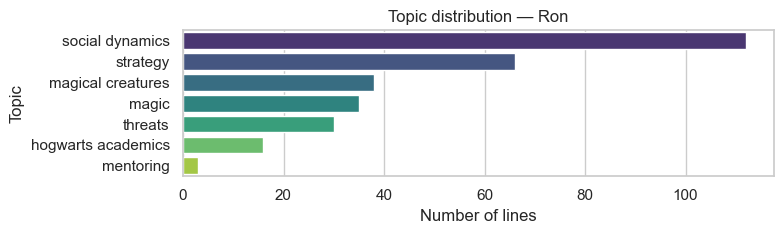

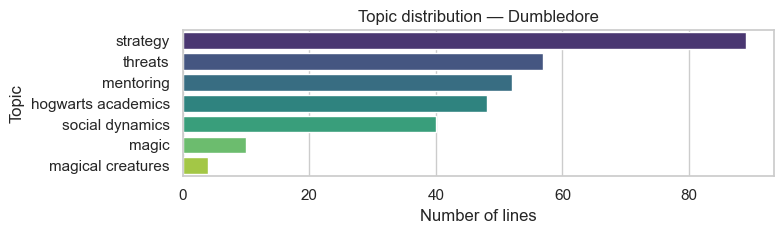

In [67]:
def plot_topic_distribution(df, character, figsize=(8,6)):
    counts = df[df["Character Name"] == character]["Topic"].value_counts()
    plt.figure(figsize=figsize)
    sns.barplot(
        x=counts.values,
        y=counts.index,
        hue=counts.index,     # assign y to hue as recommended
        dodge=False,
        palette="viridis",
        legend=False
    )
    plt.title(f"Topic distribution — {character}")
    plt.xlabel("Number of lines")
    plt.ylabel("Topic")
    plt.tight_layout()
    plt.show()

for c in dfs.keys():
    plot_topic_distribution(
        combined_df,
        c,
        figsize=(8, max(2.5, dfs[c]['Topic'].nunique() * 0.35))
    )

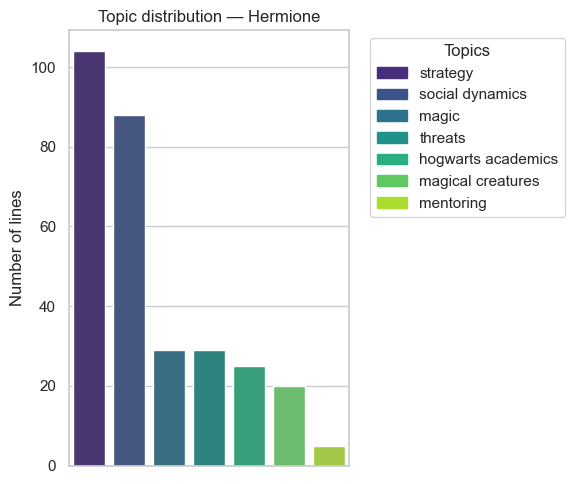

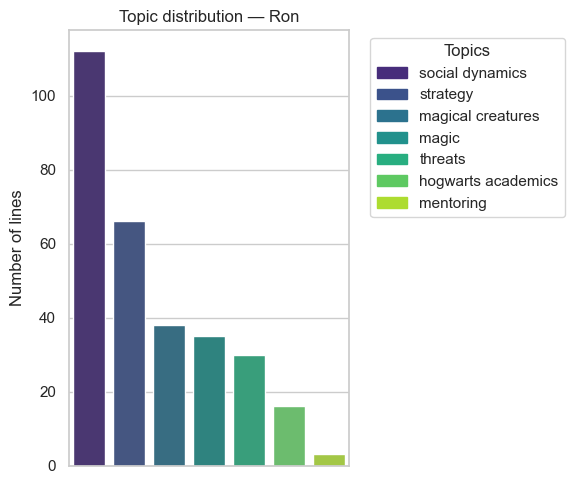

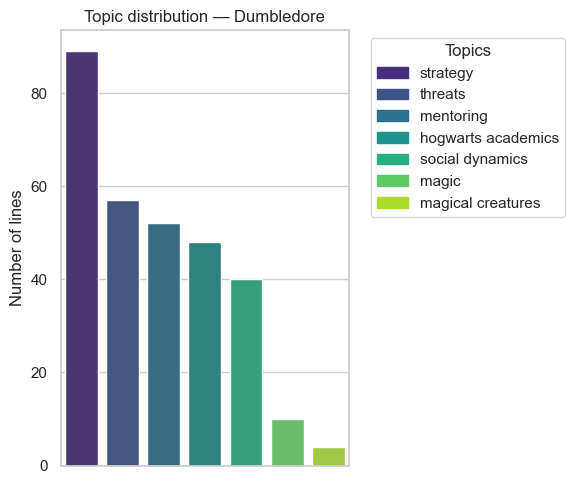

In [68]:
import matplotlib.patches as mpatches

def plot_topic_distribution(df, character, figsize=(8,6)):
    counts = df[df["Character Name"] == character]["Topic"].value_counts()

    plt.figure(figsize=figsize)

    palette = sns.color_palette("viridis", len(counts))

    # Barplot without x-axis labels
    ax = sns.barplot(
        x=counts.index,
        y=counts.values,
        palette=palette
    )

    plt.title(f"Topic distribution — {character}")
    plt.xlabel("")  # remove label
    plt.ylabel("Number of lines")

    # Remove x-axis tick labels
    plt.xticks([], [])

    # Build legend
    patches = [
        mpatches.Patch(color=palette[i], label=topic)
        for i, topic in enumerate(counts.index)
    ]
    plt.legend(handles=patches, title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


for c in dfs.keys():
    plot_topic_distribution(
        combined_df,
        c,
        figsize=(max(6, dfs[c]['Topic'].nunique()*0.8), 5)
    )


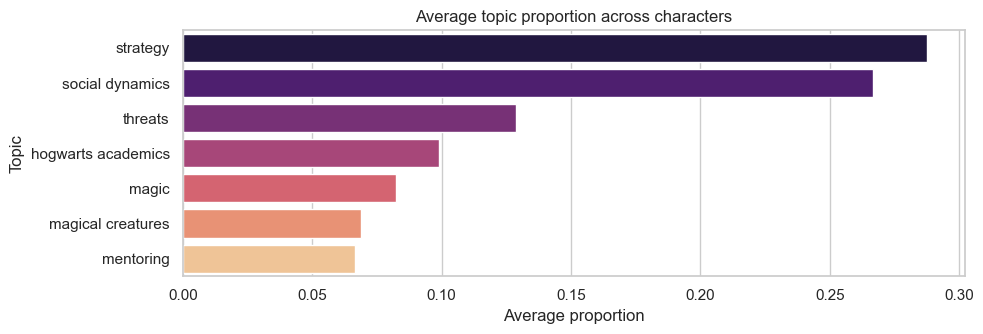

In [69]:
chars = sorted(combined_df['Character Name'].unique())
topic_props = {}

for char in chars:
    vc = combined_df[combined_df["Character Name"]==char]["Topic"].value_counts(normalize=True)
    topic_props[char] = vc

prop_df = pd.DataFrame(topic_props).fillna(0)
avg_prop = prop_df.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, max(3.5, len(avg_prop)*0.4)))
sns.barplot(x=avg_prop.values, y=avg_prop.index, palette="magma")
plt.xlabel("Average proportion")
plt.ylabel("Topic")
plt.title("Average topic proportion across characters")
plt.tight_layout()
plt.show()

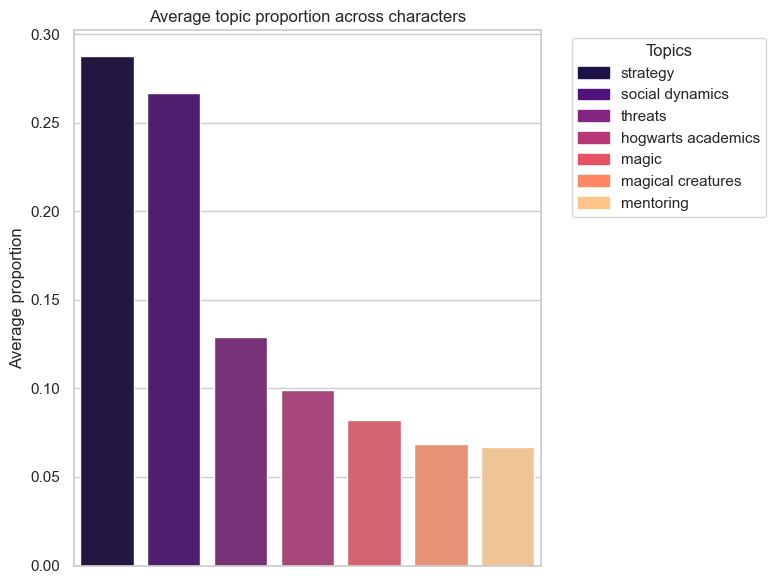

In [70]:
import matplotlib.patches as mpatches

chars = sorted(combined_df['Character Name'].unique())
topic_props = {}

for char in chars:
    vc = combined_df[combined_df["Character Name"]==char]["Topic"].value_counts(normalize=True)
    topic_props[char] = vc

prop_df = pd.DataFrame(topic_props).fillna(0)
avg_prop = prop_df.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(max(8, len(avg_prop)*0.6), 6))

palette = sns.color_palette("magma", len(avg_prop))

ax = sns.barplot(
    x=avg_prop.index,
    y=avg_prop.values,
    palette=palette
)

plt.title("Average topic proportion across characters")
plt.xlabel("")   # remove label
plt.ylabel("Average proportion")

# Remove x-axis tick labels
plt.xticks([], [])

# Build legend from topics + palette
patches = [
    mpatches.Patch(color=palette[i], label=topic)
    for i, topic in enumerate(avg_prop.index)
]

plt.legend(
    handles=patches,
    title="Topics",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

In [71]:
topic_docs = combined_df.groupby("Topic")["Dialogue"].apply(lambda s: " ".join(s)).to_dict()
topics = sorted(topic_docs.keys())
corpus = [topic_docs[t] for t in topics]

custom_stopwords = ["i'm", "know", "did", "it's", "don't", "he's", "think", "got", "that's", "come", "you're", "exactly", "certain", "yes", "different", "wait", "we've got", "they're", "like", "bit", "can't", "she's", "right", "we've", "isn't", "okay", "man"]

# Combine with built-in English stopwords
all_stopwords = list(_stop_words.ENGLISH_STOP_WORDS.union(custom_stopwords))

vectorizer = TfidfVectorizer(
    stop_words=all_stopwords,
    ngram_range=(1,2),
    min_df=1,
    max_features=30000,
    token_pattern=r"[a-zA-Z0-9']+"   # keeps contractions together
)

X = vectorizer.fit_transform(corpus)
feature_names = np.array(vectorizer.get_feature_names_out())

topic_top_terms = {}
TOP_K = 10

for i, t in enumerate(topics):
    row = X[i].toarray().ravel()
    top_idx = row.argsort()[::-1][:TOP_K]
    terms_scores = [(feature_names[j], float(row[j])) for j in top_idx]
    topic_top_terms[t] = terms_scores

In [72]:
for topic, terms in topic_top_terms.items():
    print(f"\n=== {topic} — Top {TOP_K} TF-IDF terms ===")
    for w, score in terms:
        print(f"{w:25s} {score:.4f}")


=== hogwarts academics — Top 10 TF-IDF terms ===
professor                 0.2585
points                    0.2209
post                      0.1325
tri wizard                0.1104
tournament                0.1104
house                     0.1100
hogwarts                  0.1049
school                    0.0953
gryffindor                0.0940
students                  0.0917

=== magic — Top 10 TF-IDF terms ===
potion                    0.1294
alohomora                 0.1169
wand                      0.1143
harry                     0.1143
spell                     0.0971
work                      0.0830
lumos                     0.0779
ha                        0.0779
oculus reparo             0.0779
oculus                    0.0779

=== magical creatures — Top 10 TF-IDF terms ===
scabbers                  0.3458
rat                       0.1921
spiders                   0.1595
headless                  0.1153
feet                      0.1153
nearly headless           0.1153
buckbe

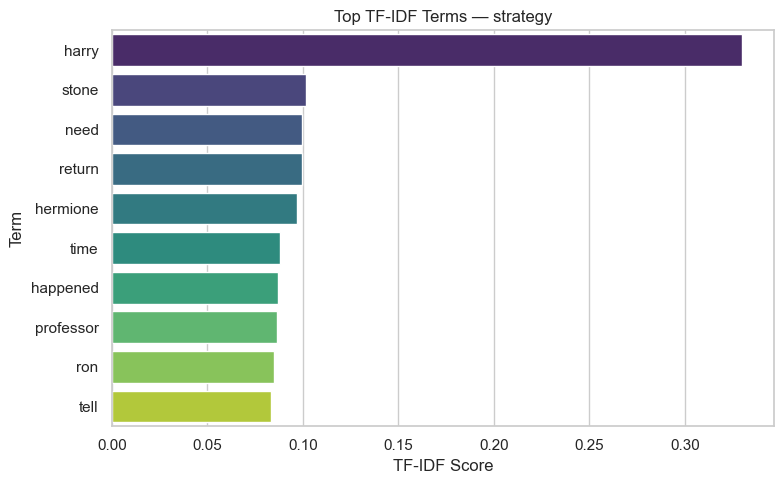

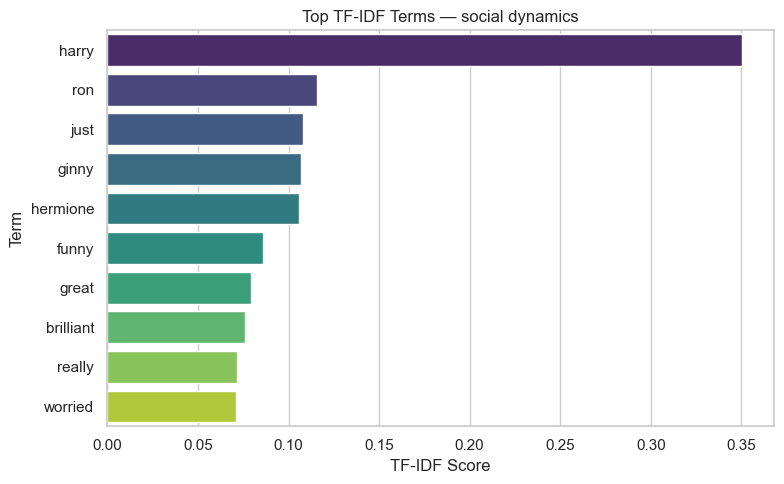

In [75]:
PLOT_TOPICS = ["strategy", "social dynamics"]

for topic in PLOT_TOPICS:
    terms_scores = topic_top_terms[topic]
    words = [w for w, _ in terms_scores]
    scores = [s for _, s in terms_scores]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=scores, y=words, palette="viridis")
    plt.title(f"Top TF-IDF Terms — {topic}")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

In [73]:
topic_lines = combined_df.groupby("Topic")["Dialogue"].apply(list).to_dict()

for topic, lines in topic_lines.items():
    print("\n" + "="*80)
    print(f"TOPIC: {topic}  ({len(lines)} lines)")
    print("="*80)

    joined_text = "\n".join(lines)
    print(joined_text[:5000])   # print first chunk so notebook isn't flooded

    if len(joined_text) > 5000:
        print("\n[... truncated for notebook display ...]\n")


TOPIC: hogwarts academics  (89 lines)
Filch is gone.
Look at you playing with your cards. Pathetic! Exams are coming.
I've always heard Hogwarts exams were frightful...
Divination is woolly; Ancient Runes is fascinating.
We're to be given quills with anti-cheating spells.
Pleasure. You two better change into your robes... You've got dirt on your nose.
Professor Lupin?
At least no one on the Gryffindor team had to buy their way in.
Madam Pomfrey will fix it.
If you two don't mind... killed or worse, expelled!
It's my fault, Professor McGonagall.
How bad is it, Neville? With Snape as Headmaster.
Not in the restricted section. Happy Christmas.
We’d break fifty school rules... very dangerous.
We just learned about red caps and hinkypunks.
We're tied with Slytherin!
I remember reading something in Herbology.
We're not supposed to be here... It's forbidden.
And what do you plan to do if this comes up in the final exam?
Since Snape set the essay.
Standard Book of Spells, Chapter 7.
Professor

In [74]:
import os

# Make a folder to store topic files
os.makedirs("topic_texts", exist_ok=True)

for topic, lines in topic_lines.items():
    # Clean the topic name for file usage
    safe_topic_name = topic.replace(" ", "_").replace("/", "_")
    filename = os.path.join("topic_texts", f"{safe_topic_name}.txt")

    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print(f"Wrote {len(lines)} lines to {filename}")

Wrote 89 lines to topic_texts/hogwarts_academics.txt
Wrote 74 lines to topic_texts/magic.txt
Wrote 62 lines to topic_texts/magical_creatures.txt
Wrote 60 lines to topic_texts/mentoring.txt
Wrote 240 lines to topic_texts/social_dynamics.txt
Wrote 259 lines to topic_texts/strategy.txt
Wrote 116 lines to topic_texts/threats.txt
